<a href="https://colab.research.google.com/github/kontaro/Desafio4/blob/main/Desafio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd
from plotnine import *
import mizani as mz
import matplotlib.pyplot as plt

Las enfermedades cardiovasculares (ECV) son la principal causa de muerte en todo el mundo y se cobran aproximadamente 17,9 millones de vidas cada año, lo que representa el 31 % de todas las muertes en todo el mundo. Cuatro de cada 5 muertes por ECV se deben a ataques cardíacos y accidentes cerebrovasculares, y un tercio de estas muertes ocurren prematuramente en personas menores de 70 años. La insuficiencia cardíaca es un evento común causado por ECV y este conjunto de datos contiene 11 características que pueden usarse para predecir una posible enfermedad cardíaca.

In [ ]:
data = pd.read_csv('heart.csv')
data.head(4)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1



    Age: age of the patient [years]
    Sex: sex of the patient [M: Male, F: Female]
    ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
    RestingBP: resting blood pressure [mm Hg]
    Cholesterol: serum cholesterol [mm/dl]
    FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
    RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
    MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
    ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
    Oldpeak: oldpeak = ST [Numeric value measured in depression]
    ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
    HeartDisease: output class [1: heart disease, 0: Normal]


Primero convertimos todos los datos categoricos a variables numericas

In [ ]:
sex = pd.get_dummies(data.Sex)
ChestPainType = pd.get_dummies(data.ChestPainType)
RestingECG = pd.get_dummies(data.RestingECG)
ExerciseAngina = pd.get_dummies(data.ExerciseAngina)
ST_Slope = pd.get_dummies(data.ST_Slope)
data = data.drop(['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], axis =1)
data = pd.concat([data, sex], axis=1)
data = pd.concat([data, ChestPainType], axis=1)
data = pd.concat([data, RestingECG], axis=1)
data = pd.concat([data, ExerciseAngina], axis=1)
data = pd.concat([data, ST_Slope], axis=1)


Luego analizaremos algunas variables de forma superficial apra entender la frecuencia en la que los pacientes tienen enfermedades cardiovasculares

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


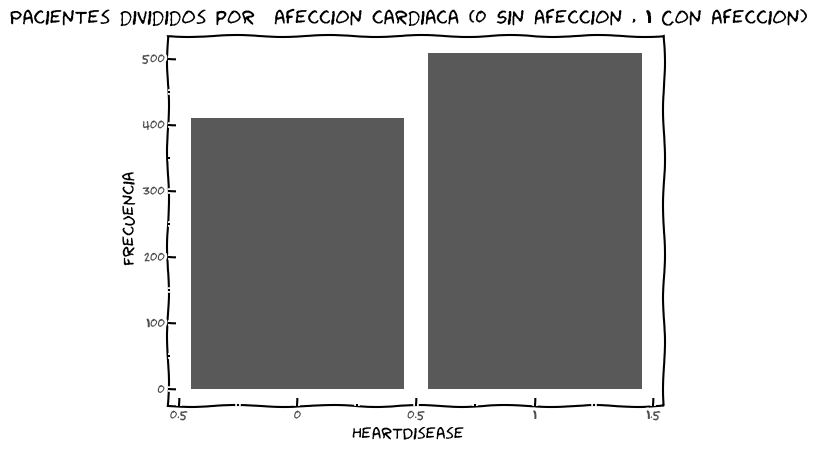

<ggplot: (8735298284477)>

In [ ]:
(ggplot(data) +
aes(x = "HeartDisease", group=1) + theme_xkcd()+ggtitle("Pacientes divididos por  afeccion cardiaca (0 Sin afeccion , 1 Con afeccion)")+
geom_bar()+
 ylab("Frecuencia")
)

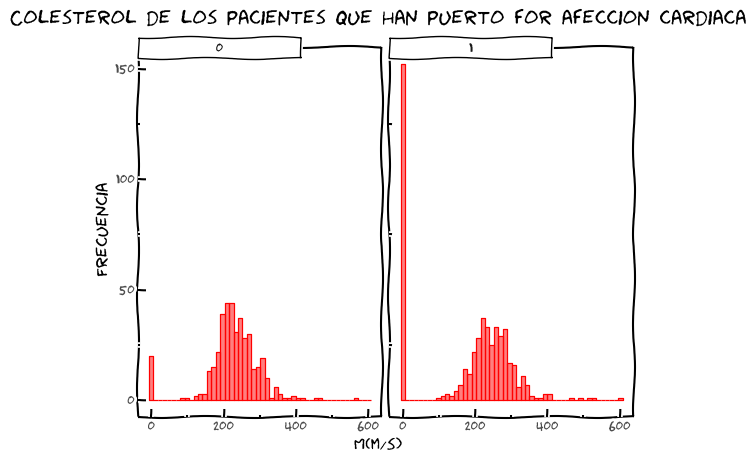

<ggplot: (8735331073717)>

In [ ]:
(ggplot(data)+
 aes(x="Cholesterol")+
 geom_histogram(color="red",fill="red",alpha=0.5,bins=50)+ 
 theme_xkcd()+
 ggtitle("Colesterol de los pacientes que tienen afeccion cardiaca")+
 xlab("M(m/s)")+
 facet_wrap("~ HeartDisease", nrow = 1)+
 ylab("Frecuencia")
)

Por raro que paresca se consideran que hay un valor 0 en el colesterol. Este dato es utilizado aunque es extraño dado que la corralacion que tiene con la afeccion cardiaca es negativo

Ahora dividimos los datos y los normalizamos para luego entrenar una red neuronal

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

Y=pd.get_dummies(data.HeartDisease)
X = data.drop(['HeartDisease'], axis =1)
transform = preprocessing.StandardScaler()
X = transform.fit(X).transform(X)

X_train, X_test, Y_train, Y_test = train_test_split( X, data.HeartDisease, test_size=0.3, random_state=2)
nY=np.array(Y_train.to_list())
Y_train = nY[:, np.newaxis]

nY=np.array(Y_test.to_list())
Y_test = nY[:, np.newaxis]

In [ ]:
import scipy as sc
def activation(x):
  return ((1/(1+np.e**(-x))) , (x * (1-x)))
class Capa():
  def __init__(self, n_conexiones: int, n_neuronas: int, activation):
    self.activation = activation
    self.W = np.random.rand(n_conexiones, n_neuronas) * 2 - 1
def crear_red(topologia: list, activation):
  red = []
  #for i in range(len(topologia) - 1):
  for l, capa in enumerate(topologia[:-1]):
    red.append( Capa(topologia[l], topologia[l+1], activation) )
  return red

def forward(red, X):
  out = [(None, X)]
  for l, capa in enumerate(red):
    z = out[-1][1] @ red[l].W # Multiplicación de matrices
    a = red[l].activation(z)[0] # La función de activación retorna el valor activado y el derivado, necesitamos el activado para el forward
    out.append((z, a)) # Guardamos todas las combinaciones para poder usar la misma función en el backpropagation
  return out

def coste(Ypred, Yesp):
  return (np.mean((Ypred - Yesp) ** 2), (Ypred - Yesp))
def train(red, X, Y, coste, learning_rate=0.001):
  # forward 
  out = forward(red, X)

  # backward pass
  delta = []
  #for i in range(len(red)-1, -1, -1): # recorrer hacie atrás del largo a 0
  for i in reversed(range(0,len(red))):
    z = out[i+1][0]
    a = out[i+1][1]
    if i == len(red)-1:
        #delta última capa
        delta.insert(0, coste(a, Y)[1] * red[i].activation(a)[1] ) # delta 0 = derivada del coste (osea Ypred - Yesp) * derivada de activación de la capa
    else:
        # delta respecto al anterior
        delta.insert(0, delta[0] @ aux_W.T * red[i].activation(a)[1]) # delta n = delta(n+1) x W(n+1).T * derivada de activación de la capa 
    aux_W = red[i].W
    # Descenso del gradiente
    red[i].W = red[i].W - out[i][1].T @ delta[0] * learning_rate # nuevoW[i] = actualW[i] - salida[i].T x delta * learning_rate

  return out[-1][1]

Epoch 0   Loss: 0.2473438817926148  Val_Loss: 0.28349054448654387
Epoch 50   Loss: 0.08835929941575574  Val_Loss: 0.10673558523558216
Epoch 100   Loss: 0.08702156180069627  Val_Loss: 0.11289596319363002
Epoch 150   Loss: 0.10538377868916471  Val_Loss: 0.15049280895674091
Epoch 200   Loss: 0.0572016447401081  Val_Loss: 0.11079708484576432
Epoch 250   Loss: 0.05363406233959107  Val_Loss: 0.13893905467581988
Epoch 300   Loss: 0.05448846366825104  Val_Loss: 0.12643877670292553
Epoch 350   Loss: 0.04910251408254752  Val_Loss: 0.11332176084841203
Epoch 400   Loss: 0.04028087163145316  Val_Loss: 0.14996672869134872
Epoch 450   Loss: 0.03560037136878501  Val_Loss: 0.15981672615320378
Epoch 500   Loss: 0.02539212492465757  Val_Loss: 0.1800863203730551
Epoch 550   Loss: 0.015647394413680092  Val_Loss: 0.1614828071931113
Epoch 600   Loss: 0.01325337142255869  Val_Loss: 0.15520502941185949
Epoch 650   Loss: 0.01309768458274926  Val_Loss: 0.15534743238575138
Epoch 700   Loss: 0.011147440495220947  

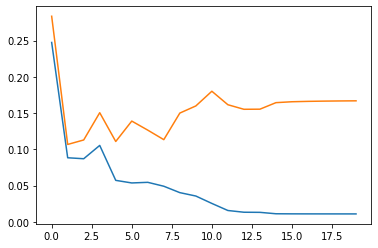

In [ ]:
topologia = [X_train.shape[1], 32, 64, 32, 16, 8, 1]
red = crear_red(topologia, activation)


loss = []
val_loss=[]
for i in range(1000):
  pY = train(red, X_train, Y_train, coste, learning_rate=0.05)
  if i % 50 == 0:
    costo = coste(pY, Y_train)[0]
    prediccion = forward(red, X_test)
    costo2=coste(prediccion[-1][1],Y_test)[0]
    
    print(f'Epoch {i}   Loss: {costo}  Val_Loss: {costo2}')
    loss.append(costo)
    val_loss.append(costo2)
    

    
plt.plot(range(len(loss)), loss)
plt.plot(range(len(val_loss)), val_loss)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error,accuracy_score
prediccion = forward(red, X_test)[-1][1]

print(mean_absolute_error(Y_test, np.trunc(prediccion)))
print(accuracy_score(Y_test, np.trunc(prediccion)))

0.5181159420289855
0.48188405797101447


# Red neuronal con Tensorflow

Ahora implementamos la misma red utilizando la biblioteca de tensowflow

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, data.HeartDisease, test_size=0.3, random_state=2)

In [ ]:
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1),
])
model.compile(loss='mse', optimizer='adam')

In [ ]:
history = model.fit(X_train, Y_train, epochs=1000, batch_size=100, validation_split=0.1)

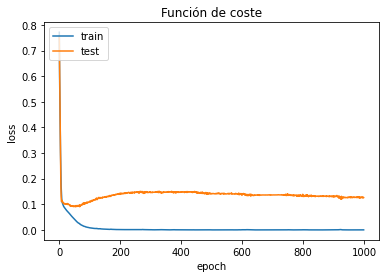

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Función de coste')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictedHD=model.predict(X_test)


print(mean_absolute_error(Y_test, predictedHD))
print(accuracy_score(Y_test,  np.trunc(predictedHD)))

0.2720980021454718
0.6268115942028986


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=2)

In [ ]:
model2 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(2 , activation='softmax'),
    
])
model2.compile(loss='mse', optimizer='adam')

In [ ]:
history = model2.fit(X_train, Y_train, epochs=1000, batch_size=100, validation_split=0.1)

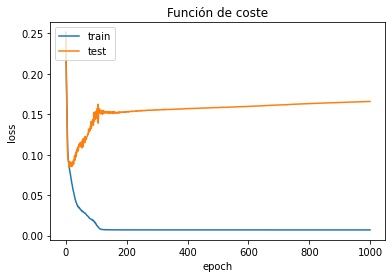

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Función de coste')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix, precision_score
Y_pred = model2.predict(X_test)
Y_exp = Y_test.to_numpy()
for i in range(len(Y_pred)):
  Y_pred[i] = np.array([1 if Y_pred[i][j] == np.max(Y_pred[i]) else 0 for j in range(len(Y_pred[i]))])
  

print(accuracy_score(Y_exp, Y_pred))
print(classification_report(Y_exp, Y_pred))

matriz_confusion = multilabel_confusion_matrix(Y_exp, Y_pred)

0.8260869565217391
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       133
           1       0.81      0.86      0.84       143

   micro avg       0.83      0.83      0.83       276
   macro avg       0.83      0.82      0.83       276
weighted avg       0.83      0.83      0.83       276
 samples avg       0.83      0.83      0.83       276



In [ ]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y.values.argmax(axis=1), y_predict.argmax(axis=1))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax = ax); 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['no heart disease', 'heart disease']); ax.yaxis.set_ticklabels(['no heart disease', 'heart disease'])

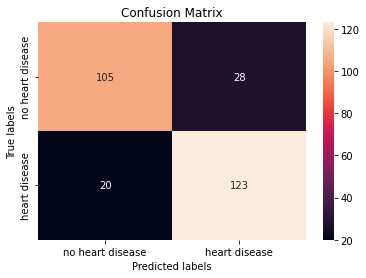

In [ ]:

plot_confusion_matrix(Y_test,Y_pred)